In [6]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
df = pd.read_csv('data/MY2022_Fuel_Consumption_Ratings.csv')
df.columns = df.columns.str.lower()
df.head()

,model year,make,model,vehicle class,engine size(l),cylinders,transmission,fuel type,fuel consumption (city (l/100 km),fuel consumption(hwy (l/100 km)),fuel consumption(comb (l/100 km)),fuel consumption(comb (mpg)),co2 emissions(g/km),co2 rating,smog rating
0,2022,Acura,ILX,Compact,2.4,4,AM8,Z,9.9,7.0,8.6,33,200,6,3
1,2022,Acura,MDX SH-AWD,SUV: Small,3.5,6,AS10,Z,12.6,9.4,11.2,25,263,4,5
2,2022,Acura,RDX SH-AWD,SUV: Small,2.0,4,AS10,Z,11.0,8.6,9.9,29,232,5,6
3,2022,Acura,RDX SH-AWD A-SPEC,SUV: Small,2.0,4,AS10,Z,11.3,9.1,10.3,27,242,5,6
4,2022,Acura,TLX SH-AWD,Compact,2.0,4,AS10,Z,11.2,8.0,9.8,29,230,5,7


In [8]:
print("Number of samples: %.0f" % df.shape[0])
print("Number of features: %.0f" % df.shape[1])

Number of samples: 946
Number of features: 15


## Data Validation

In [9]:
df.isnull().sum()

model year                           0
make                                 0
model                                0
vehicle class                        0
engine size(l)                       0
cylinders                            0
transmission                         0
fuel type                            0
fuel consumption (city (l/100 km)    0
fuel consumption(hwy (l/100 km))     0
fuel consumption(comb (l/100 km))    0
fuel consumption(comb (mpg))         0
co2 emissions(g/km)                  0
co2 rating                           0
smog rating                          0
dtype: int64

The dataset is clean.

In [14]:
df['model year'].value_counts()

2022    946
Name: model year, dtype: int64

In [15]:
del df['model year']

In [19]:
df['make'].nunique()

39

In [10]:
from sklearn.model_selection import train_test_split

df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=11)
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=11)

## Exploratory Data Analysis

In [20]:
# Creating target series
y_train = df_train['co2 emissions(g/km)']
y_val = df_val['co2 emissions(g/km)']

# Removing target from train sets
df_train.drop(['co2 emissions(g/km)'], axis=1, inplace=True)
df_val.drop(['co2 emissions(g/km)'], axis=1, inplace=True)

In [21]:
from sklearn.feature_extraction import DictVectorizer

dict_train = df_train.to_dict(orient='records')
dict_val = df_val.to_dict(orient='records')

dv = DictVectorizer(sparse=False)

X_train = dv.fit_transform(dict_train)
X_val = dv.transform(dict_val)

In [30]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

rfr = RandomForestRegressor()

rfr.fit(X_train, y_train)

y_pred_train = rfr.predict(X_train)
y_pred_val = rfr.predict(X_val)

rfr_score_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rfr_score_val = np.sqrt(mean_squared_error(y_val, y_pred_val))

print("ROC AUC Train = {:0.3f}".format(rfr_score_train))
print("ROC AUC Validation = {:0.3f}".format(rfr_score_val))

ROC AUC Train = 2.542
ROC AUC Validation = 7.314


In [ ]:
dict_test = df_test.to_dict(orient='records')
X_test = dv.fit_transform(dict_test)

y_test = df_test['cooling_load']

y_pred_test = rfr.predict(X_test)

score_model_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

print("RMSE Test: ", score_model_test)

In [32]:
rmses = []
for n in range(10, 201, 10):

    rfr = RandomForestRegressor(n_estimators=n, random_state=3)
    rfr.fit(X_train, y_train)

    y_pred = rfr.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    print('%3s -> %.3f' % (n, rmse))

    rmses.append(rmse)

 10 -> 8.706
 20 -> 7.698
 30 -> 7.686
 40 -> 7.509
 50 -> 7.459
 60 -> 7.507
 70 -> 7.579
 80 -> 7.745
 90 -> 7.968
100 -> 7.765
110 -> 7.834
120 -> 7.602
130 -> 7.548
140 -> 7.542
150 -> 7.554
160 -> 7.675
170 -> 7.543
180 -> 7.555
190 -> 7.603
200 -> 7.590


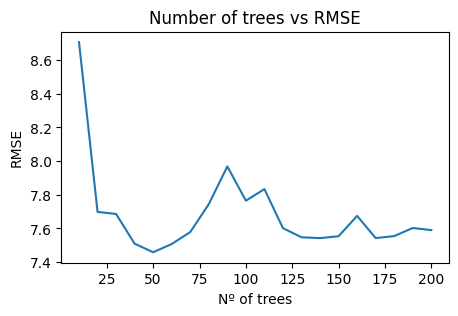

In [34]:
num_trees = range(10, 201, 10)

plt.figure(figsize=(5,3))
plt.plot(num_trees, rmses)
plt.xlabel('Nº of trees')
plt.ylabel('RMSE')
plt.title('Number of trees vs RMSE')
plt.show()

In [35]:
all_rmses_depth = {}

for depth in [5, 10, 20]:
    print('max_depth: %s' % depth)

    rmses = []
    for trees in range(10, 201, 10):
        rfr = RandomForestRegressor(n_estimators=trees, 
                                    max_depth=depth, 
                                    random_state=3)
        rfr.fit(X_train, y_train)

        y_pred = rfr.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        print('%3s -> %.3f' % (trees, rmse))

        rmses.append(rmse)
    
    print()

    all_rmses_depth[depth] = rmses

max_depth: 5
 10 -> 10.183
 20 -> 10.125
 30 -> 10.347
 40 -> 9.588
 50 -> 9.425
 60 -> 9.374
 70 -> 9.329
 80 -> 9.446
 90 -> 9.310
100 -> 9.346
110 -> 9.193
120 -> 9.036
130 -> 9.151
140 -> 9.108
150 -> 9.005
160 -> 9.053
170 -> 9.027
180 -> 9.145
190 -> 9.312
200 -> 9.270

max_depth: 10
 10 -> 5.429
 20 -> 5.555
 30 -> 5.966
 40 -> 5.770
 50 -> 6.133
 60 -> 6.421
 70 -> 6.731
 80 -> 6.844
 90 -> 6.927
100 -> 6.857
110 -> 6.781
120 -> 6.823
130 -> 6.839
140 -> 6.875
150 -> 6.872
160 -> 6.919
170 -> 7.075
180 -> 7.117
190 -> 7.214
200 -> 7.249

max_depth: 20
 10 -> 8.706
 20 -> 7.698
 30 -> 7.686
 40 -> 7.509
 50 -> 7.459
 60 -> 7.507
 70 -> 7.579
 80 -> 7.745
 90 -> 7.968
100 -> 7.765
110 -> 7.834
120 -> 7.602
130 -> 7.548
140 -> 7.542
150 -> 7.554
160 -> 7.675
170 -> 7.543
180 -> 7.555
190 -> 7.603
200 -> 7.590



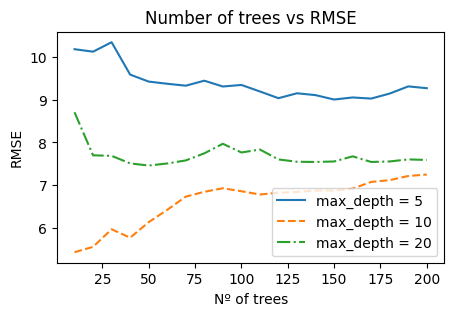

In [37]:
plt.figure(figsize=(5,3))
plt.plot(num_trees, all_rmses_depth[5], '-', label='max_depth = 5')
plt.plot(num_trees, all_rmses_depth[10], '--', label='max_depth = 10')
plt.plot(num_trees, all_rmses_depth[20], '-.', label='max_depth = 20')
plt.xlabel('Nº of trees')
plt.ylabel('RMSE')
plt.legend()
plt.title('Number of trees vs RMSE')
plt.show()

In [41]:
all_rmses_leaf = {}

for samples in [3, 5, 10]:
    print('min_samples_leaf: %s' % samples)

    rmses = []
    for trees in range(10, 201, 10):
        rfr = RandomForestRegressor(n_estimators=trees,
                                     max_depth=10, 
                                     min_samples_leaf=samples, 
                                     random_state=3)
        rfr.fit(X_train, y_train)

        y_pred = rfr.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        print('%3s -> %.3f' % (trees, rmse))

        rmses.append(rmse)
    
    print()

    all_rmses_leaf[samples] = rmses

min_samples_leaf: 3
 10 -> 9.042
 20 -> 8.048
 30 -> 8.312
 40 -> 8.335
 50 -> 8.018
 60 -> 8.288
 70 -> 8.277
 80 -> 8.323
 90 -> 8.595
100 -> 8.558
110 -> 8.344
120 -> 8.373
130 -> 8.397
140 -> 8.284
150 -> 8.304
160 -> 8.405
170 -> 8.483
180 -> 8.505
190 -> 8.610
200 -> 8.635

min_samples_leaf: 5
 10 -> 8.511
 20 -> 8.173
 30 -> 8.535
 40 -> 9.270
 50 -> 9.248
 60 -> 8.969
 70 -> 8.796
 80 -> 8.586
 90 -> 8.649
100 -> 8.653
110 -> 8.703
120 -> 8.663
130 -> 8.607
140 -> 8.515
150 -> 8.480
160 -> 8.480
170 -> 8.416
180 -> 8.573
190 -> 8.533
200 -> 8.626

min_samples_leaf: 10
 10 -> 9.820
 20 -> 10.140
 30 -> 9.474
 40 -> 9.106
 50 -> 8.986
 60 -> 9.137
 70 -> 9.103
 80 -> 9.208
 90 -> 9.161
100 -> 9.188
110 -> 9.200
120 -> 9.105
130 -> 9.106
140 -> 9.087
150 -> 9.069
160 -> 9.139
170 -> 9.145
180 -> 9.178
190 -> 9.249
200 -> 9.364



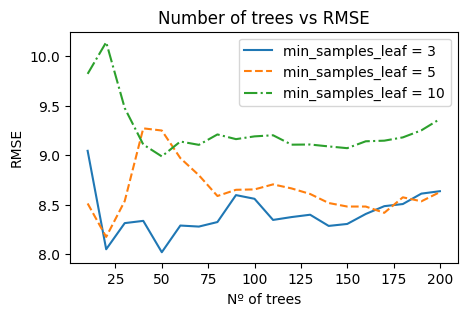

In [42]:
plt.figure(figsize=(5,3))
plt.plot(num_trees, all_rmses_leaf[3], '-', label='min_samples_leaf = 3')
plt.plot(num_trees, all_rmses_leaf[5], '--', label='min_samples_leaf = 5')
plt.plot(num_trees, all_rmses_leaf[10], '-.', label='min_samples_leaf = 10')
plt.xlabel('Nº of trees')
plt.ylabel('RMSE')
plt.legend()
plt.title('Number of trees vs RMSE')
plt.show()

In [43]:
rfr_final = RandomForestRegressor(n_estimators=50, 
                                  max_depth=10, 
                                  min_samples_leaf=3,
                                  random_state=3)

rfr_final.fit(X_train, y_train)

y_pred_train = rfr_final.predict(X_train)
y_pred_val = rfr_final.predict(X_val)

rfr_score_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rfr_score_val = np.sqrt(mean_squared_error(y_val, y_pred_val))

print("ROC AUC Train = {:0.3f}".format(rfr_score_train))
print("ROC AUC Validation = {:0.3f}".format(rfr_score_val))

ROC AUC Train = 5.334
ROC AUC Validation = 8.018
